In [116]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [117]:
import tensorflow as tf
from tensorflow.keras import layers

In [118]:
from scipy.optimize import minimize
import nevergrad as ng

## Data

In [176]:
df = pd.DataFrame(columns=['Pressure','Temprerature','Speed','ProductionYield'])

In [239]:
df['Pressure'] = np.random.randint(low= 2, high=10, size=2000)
df['Temprerature'] = np.random.randint(10, 30, size=2000)
df['Speed'] = np.random.weibull(2, size=2000)
df['ProductionYield'] = (df['Pressure'])**2 + df['Temprerature'] * df['Speed'] + 10
df['ProductionYield']= df['ProductionYield'].clip(0, 100)

In [282]:
print(df.head())

   Pressure  Temprerature     Speed  ProductionYield
0         7            20  1.810557        95.211139
1         2            29  0.674221        33.552409
2         8            17  0.537533        83.138065
3         3            24  1.945914        65.701938
4         6            23  0.514679        57.837610


In [241]:
df.describe()

,Pressure,Temprerature,Speed,ProductionYield
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,5.387000,19.193000,0.886962,59.896676
std,2.271522,5.739444,0.465351,24.848748
min,2.000000,10.000000,0.022999,14.928041
25%,3.000000,14.000000,0.539461,38.580321
50%,5.000000,19.000000,0.838304,57.487117
75%,7.000000,24.000000,1.159702,80.894086
max,9.000000,29.000000,2.856172,100.000000


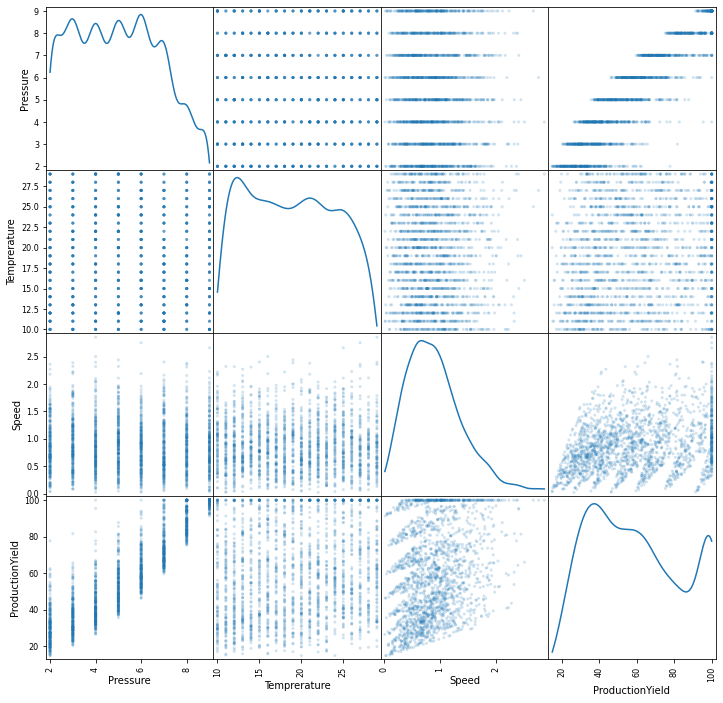

In [242]:
from pandas.plotting import scatter_matrix

#now plot using pandas 
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde');

## Prediction algorithm

In [243]:
x_train, x_test, y_train, y_test = train_test_split(df[['Pressure','Temprerature','Speed']].values, df['ProductionYield'].values, test_size=0.33, random_state=42)

In [244]:
def build_model():
    
    # create model
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(layers.Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [245]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 15])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

In [246]:
model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_32 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [247]:
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    verbose=0, epochs=1000)

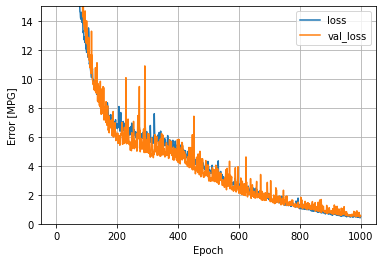

In [248]:
plot_loss(history)

In [249]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(x_test))

0.9990325152160419

In [250]:
tp_indx = 4
print(f"real value: {y_test[tp_indx]}, model predicted: {model.predict(x_test[tp_indx].reshape(1,-1))}")

real value: 20.367906203672227, model predicted: [[20.50421]]


## Multi-dimensional optimization

### 'Nelder-Mead'

In [270]:
def wrapper(x, *args) -> float:
    
    network_input = x.reshape(1,-1)
    network_output = model.predict(network_input, *args)
    scipy_output = float(network_output)
    
    if (scipy_output > 0) & (scipy_output < 110):
        return -scipy_output
    
    else:
        return 1000000

In [267]:
x0 = x_train[-1].reshape(1,-1)
res = minimize(wrapper, x0, method='Nelder-Mead', tol=1e-6)

In [268]:
res

 final_simplex: (array([[11.07007426, 19.05658301,  2.19152852],
       [11.07007426, 19.05658295,  2.19152853],
       [11.07007426, 19.05658294,  2.19152853],
       [11.07007429, 19.05658237,  2.19152859]]), array([-109.99999237, -109.99999237, -109.99999237, -109.99999237]))
           fun: -109.99999237060547
       message: 'Optimization terminated successfully.'
          nfev: 222
           nit: 95
        status: 0
       success: True
             x: array([11.07007426, 19.05658301,  2.19152852])

In [269]:
model.predict(res.x.reshape(1,-1))

array([[109.99999]], dtype=float32)

### Bound 'L-BFGS-B'

In [279]:
x0 = x_train[-5].reshape(1,-1)
bnds = ((2, 10), (10, 40), (0, 4))
res = minimize(wrapper, x0, method='L-BFGS-B',bounds=bnds, tol=1e-6)

In [280]:
res

      fun: -50.364444732666016
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 2.        , 26.        ,  1.42230335])

In [281]:
model.predict(res.x.reshape(1,-1))

array([[50.364445]], dtype=float32)